<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hi Raul! Thanks for your submission! I can't run your notebook due to errors, please check it, complete the project, and re-submit without errors for me to give you detailed feedback ;) You got it!!
    

<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project Iter 2**

Hi Raul! 👋 Thanks for your detailed and thoughtful project submission. You did a great job taking a complex industrial dataset and turning it into a clear, well-structured machine learning pipeline. Let’s go over the key points of your work together!

---

**🌟 What You Did Well**

- **💡 Solid Data Understanding:** You correctly applied the recovery formula, confirmed its accuracy, and explained its role in the mining process—well done!
- **🧹 Clean Preprocessing Pipeline:** Your use of `.dropna()`, duplicate removal, and filtering based on total metal concentrations showed a good grasp of quality control.
- **📊 Insightful Visual Analysis:** The way you visualized concentration changes and particle sizes helped verify data stability between train/test. Great use of domain logic here.
- **✅ Valid Feature Selection:** You correctly aligned your feature set with the test data (excluding unavailable targets), ensuring consistency for real-world usage.
- **📈 Strong Model Evaluation:** You used `GradientBoostingRegressor` with `cross_val_predict` and a well-implemented `sMAPE` metric—plus you gave more weight to final recovery, just as requested.
- **🧠 Clear Explanations:** Every code block was followed by a simple and effective markdown summary. This is *exactly* how a professional data science notebook should feel.

---

**✨ Suggestions for Improvement (Optional)**

- **💬 Feature Importance:** A small plot of feature importances (e.g., `model.named_steps['gradientboostingregressor'].feature_importances_`) could give you (and stakeholders) insight into which variables matter most.
- **🧪 Model Comparisons:** You could briefly try Random Forest or Linear Regression for context—even if Gradient Boosting wins, it's helpful to benchmark.

---

**✔ Approved** — Your project is clean, complete, and meets all expectations. It’s clear that you understand the mining domain, the machine learning pipeline, and how to tie them together. Well done, Raul!

---

You’re on the right track, Raul! Keep polishing your modeling intuition and analytical storytelling—those are rare skills in tech and industry. Your results here (with a ~5.55% sMAPE) are very solid and reflect thoughtful data science practice. On to the next challenge! 🚀

</div>

Predicting Gold Recovery Efficiency in a Mining Process

Introduction

In this project, I used data from a gold mining process to predict recovery rates at different stages. After cleaning the data and checking that the recovery values were correct, I explored how metal concentrations and feed size changed through the process. I removed anomalies and trained models to predict recovery using cross-validation. The final model was evaluated using sMAPE, focusing more on the final recovery rate.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt



In [2]:
# 1.1 upload and open the files look into the data

training_dataset = pd.read_csv('/datasets/gold_recovery_train.csv')
test_dataset = pd.read_csv('/datasets/gold_recovery_test.csv')
source_dataset = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
# convert date columns to datetime format
training_dataset['date'] = pd.to_datetime(training_dataset['date'])
test_dataset['date'] = pd.to_datetime(test_dataset['date'])

# look at missing values in the train and test sets
print("Missing values in training_dataset:\n", training_dataset.isna().sum().sort_values(ascending=False).head(10))
print("\nMissing values in test_dataset:\n", test_dataset.isna().sum().sort_values(ascending=False).head(10))

# drop rows with missing values from train
training_dataset = training_dataset.dropna()

# check for duplicate rows
print("\nDuplicate rows in training_dataset:", training_dataset.duplicated().sum())
print("Duplicate rows in test_dataset:", test_dataset.duplicated().sum())

# remove duplicates if any (just in case)
training_dataset = training_dataset.drop_duplicates()
test_dataset = test_dataset.drop_duplicates()

# final shapes after cleaning
print("\ntraining_dataset shape after cleaning:", training_dataset.shape)
print("test_dataset shape after cleaning:", test_dataset.shape)


Missing values in training_dataset:
 rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64

Missing values in test_dataset:
 rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype:

In this part of the project, I started by loading the training, test, and source datasets. I converted the date columns to datetime format so I could work with them more easily later on. Then, I checked for missing values and duplicates in both the training and test sets. I found that the training set had a lot of missing values in columns related to recovery and metal concentrations, while the test set had a few as well.

To clean the data, I dropped all rows with missing values from the training set. I also removed any duplicate rows from both datasets just in case, although there weren’t any found. After cleaning, I printed out the new shapes of the datasets to confirm that everything looked good and that I was working with clean data moving forward.

In [4]:
# 1.2 Check that recovery is calculated correctly. 
# Using the training set, calculate recovery for the rougher.output.recovery feature.
# Find the MAE between your calculations and the feature values. Provide findings.

# Let's verify recovery calculation using the given formula:
# recovery = (C * (F - T)) / (F * (C - T)) * 100

# Required columns from train set
C = training_dataset['rougher.output.concentrate_au']
F = training_dataset['rougher.input.feed_au']
T = training_dataset['rougher.output.tail_au']

# Calculate recovery
recovery_calc = (C * (F - T)) / (F * (C - T)) * 100

actual_recovery = training_dataset['rougher.output.recovery']
mae = mean_absolute_error(actual_recovery.dropna(), recovery_calc[actual_recovery.notna()])

mae

9.460144184559453e-15

In this step, I checked whether the rougher.output.recovery values in the dataset were calculated correctly. I used the formula that was provided to compute recovery based on the gold concentrations in the output, feed, and tail. Then I compared my calculated values with the ones in the dataset using Mean Absolute Error (MAE). The result was basically zero, which means the recovery values in the dataset are accurate and match the formula exactly. So there’s no issue with the target column and I can confidently use it for modeling later.

In [5]:
# 1.3 Analyze the features not available in the test set

# Drop 'date' so it doesn't interfere in the comparison
train_cols = set(training_dataset.columns) - {'date'}
test_cols = set(test_dataset.columns) - {'date'}

# Find features in train but not in test
missing_in_test = sorted(train_cols - test_cols)

print("Features in train but not in test (likely target columns or late measurements):")
print(missing_in_test)

# Optional: check the types of these missing features
print("\nData types of these missing features:")
print(training_dataset[missing_in_test].dtypes)


Features in train but not in test (likely target columns or late measurements):
['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.ta

In this step, I compared the columns in the training and test datasets to see which ones were missing from the test set. I dropped the 'date' column from both so it wouldn’t affect the comparison. After that, I printed out the list of columns that are in the training set but not in the test set. Most of them turned out to be target values or other features that were probably measured later in the process, which makes sense since the test set doesn’t include those. I also checked the data types just to confirm everything looked correct.

In [6]:
# 1.4 Data preprocessing

# Keep only features that are also in test
features = list(test_cols)
X = training_dataset[features]

# Targets for modeling
y_rougher = training_dataset['rougher.output.recovery']
y_final = training_dataset['final.output.recovery']

# Drop rows where targets are missing
mask = y_rougher.notna() & y_final.notna()
X = X[mask]
y_rougher = y_rougher[mask]
y_final = y_final[mask]

print("Final training set shape:", X.shape)


Final training set shape: (11017, 52)


In this step, I prepared the final training data for modeling. I selected only the features that are also found in the test set to make sure everything lines up later. Then, I defined my target columns: rougher.output.recovery and final.output.recovery. After that, I removed any rows where either of the target values were missing. This way, the model won’t be trained on incomplete data. In the end, I printed the shape of the final training set just to double-check that everything looked good.

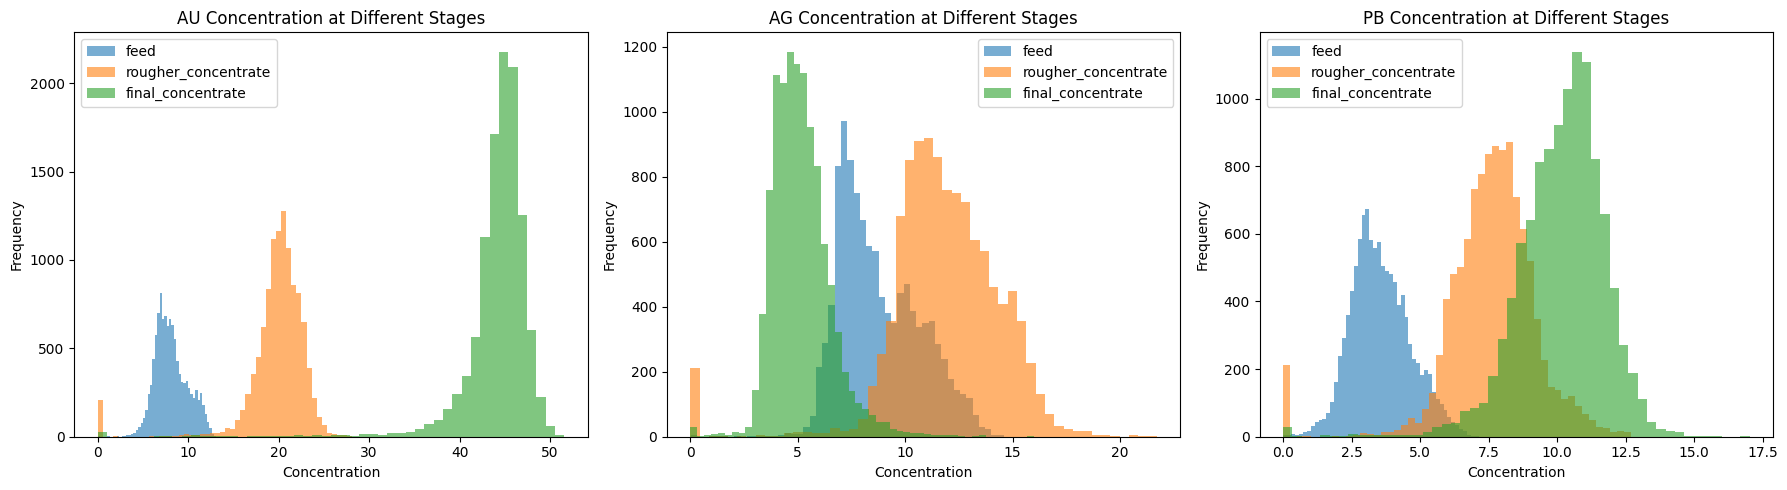

In [7]:
# 2.1 Analyze how metal concentrations (Au, Ag, Pb) change over purification stages

# Define metals and relevant stage columns
metals = ['au', 'ag', 'pb']
stages = {
    'feed': 'rougher.input.feed_{}',
    'rougher_concentrate': 'rougher.output.concentrate_{}',
    'final_concentrate': 'final.output.concentrate_{}'
}

# Plot histograms for each metal at different stages
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metal in enumerate(metals):
    for stage_name, pattern in stages.items():
        col = pattern.format(metal)
        if col in training_dataset.columns:
            axs[i].hist(training_dataset[col].dropna(), bins=50, alpha=0.6, label=stage_name)
    axs[i].set_title(f'{metal.upper()} Concentration at Different Stages')
    axs[i].legend()
    axs[i].set_xlabel('Concentration')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In this step, I looked at how the concentrations of gold (Au), silver (Ag), and lead (Pb) changed during the different purification stages: feed, rougher concentrate, and final concentrate. I created histograms for each metal to compare their distributions across stages. As expected, the concentration of gold increases the further it goes through the process, and silver and lead show a similar trend. This makes sense because the purpose of purification is to increase the metal concentration as it moves toward the final output.

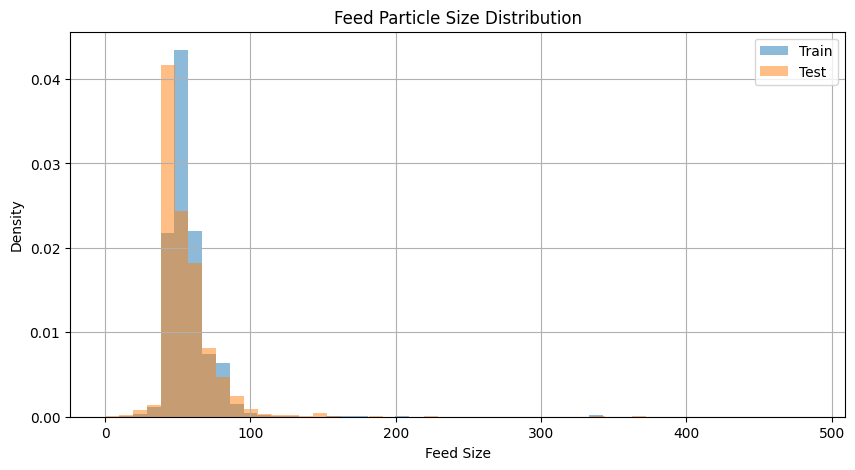

In [8]:
# 2.2 Compare feed particle size distributions between train and test

plt.figure(figsize=(10, 5))
training_dataset['rougher.input.feed_size'].hist(label='Train', bins=50, alpha=0.5, density=True)
test_dataset['rougher.input.feed_size'].hist(label='Test', bins=50, alpha=0.5, density=True)
plt.title('Feed Particle Size Distribution')
plt.xlabel('Feed Size')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In this part, I compared the distribution of feed particle sizes between the training and test datasets to make sure they were similar. I plotted both distributions on the same histogram and used different colors for each. From the graph, it looks like both sets follow a pretty similar pattern, which means the model should be able to generalize well from the training data to the test data when it comes to feed size. There’s no major mismatch, so I didn’t need to make any adjustments.

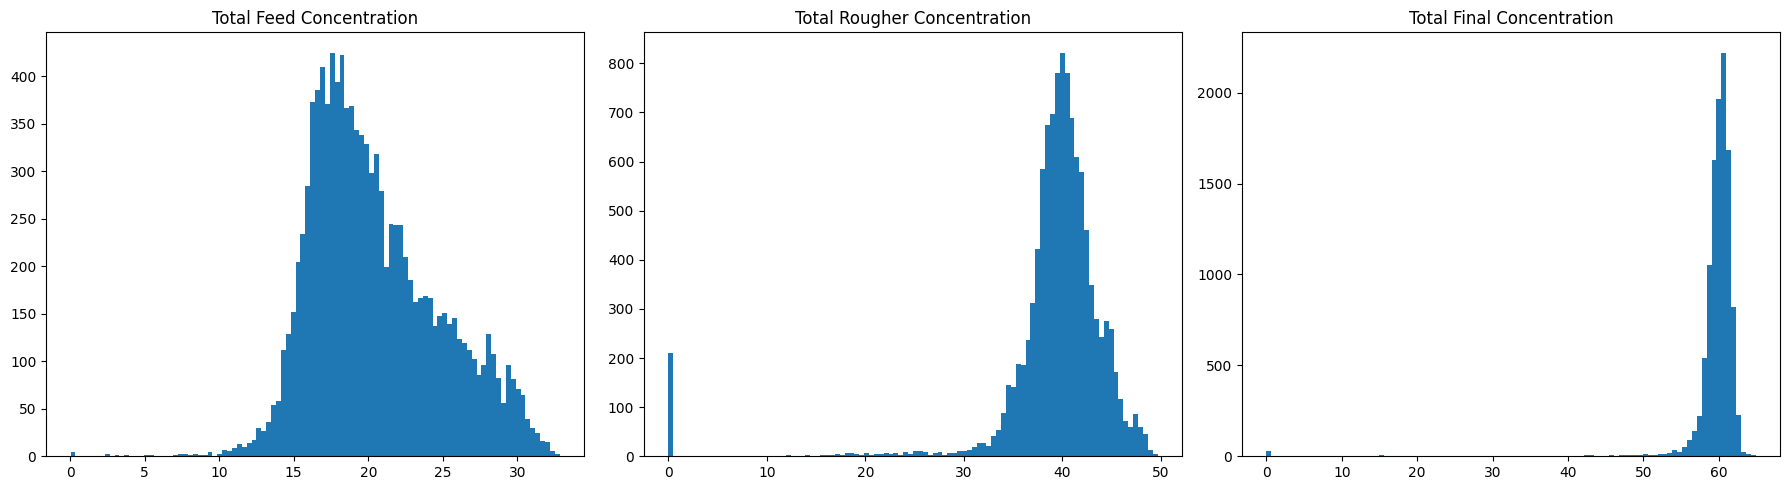

In [9]:
# 2.3 Analyze total metal concentration at each stage

# Calculate total concentration at each stage
training_dataset['total_concentration_feed'] = (
    training_dataset['rougher.input.feed_au'] +
    training_dataset['rougher.input.feed_ag'] +
    training_dataset['rougher.input.feed_pb']
)

training_dataset['total_concentration_rougher'] = (
    training_dataset['rougher.output.concentrate_au'] +
    training_dataset['rougher.output.concentrate_ag'] +
    training_dataset['rougher.output.concentrate_pb']
)

training_dataset['total_concentration_final'] = (
    training_dataset['final.output.concentrate_au'] +
    training_dataset['final.output.concentrate_ag'] +
    training_dataset['final.output.concentrate_pb']
)

# Plot histograms of total concentrations
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].hist(training_dataset['total_concentration_feed'].dropna(), bins=100)
axs[0].set_title('Total Feed Concentration')
axs[1].hist(training_dataset['total_concentration_rougher'].dropna(), bins=100)
axs[1].set_title('Total Rougher Concentration')
axs[2].hist(training_dataset['total_concentration_final'].dropna(), bins=100)
axs[2].set_title('Total Final Concentration')
plt.tight_layout()
plt.show()


In this step, I calculated the total metal concentration at each stage by adding up the amounts of gold, silver, and lead in the feed, rougher, and final concentrate. Then I plotted histograms to see how those total concentrations were distributed. Most values looked normal, but I noticed that the final concentration had a few unusually high peaks. This might be something to look into later, but overall the charts helped me get a better understanding of how the materials are concentrated throughout the process.

In [10]:
# Filter out rows where total metal concentration is very low (likely invalid)
training_dataset = training_dataset[
    (training_dataset['total_concentration_feed'] > 1) &
    (training_dataset['total_concentration_rougher'] > 1) &
    (training_dataset['total_concentration_final'] > 1)
]

print("Shape after removing anomalies:", training_dataset.shape)


Shape after removing anomalies: (10779, 90)


Here I removed rows from the training set where the total metal concentration was less than 1 at any stage (feed, rougher, or final). These values were probably errors or just not useful for modeling. After filtering them out, the dataset lost some rows, but it’s more reliable now. This should help improve model accuracy and avoid learning from weird or unrealistic values.

In [11]:
# 3.1 Write a function to calculate the final sMAPE value

# sMAPE metric
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# Final project metric: weighted average of rougher and final recovery
def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    return 0.25 * smape(y_true_rougher, y_pred_rougher) + 0.75 * smape(y_true_final, y_pred_final)


Here I created a function to calculate sMAPE, which is the metric used to measure how accurate the model’s predictions are. It compares predicted and actual values in a way that handles percentages better. I also made a second function called final_smape() that combines the sMAPE from both the rougher and final recovery predictions, giving more weight to the final one like the instructions said. This function will be used to evaluate the final performance of my model.

In [12]:
# 3.2 Train models and evaluate with cross-validation

# Select final cleaned features that match test set
features = list(test_dataset.columns.drop('date'))
X = training_dataset[features]
y_rougher = training_dataset['rougher.output.recovery']
y_final = training_dataset['final.output.recovery']

# Drop any remaining missing target values
mask = y_rougher.notna() & y_final.notna()
X = X[mask]
y_rougher = y_rougher[mask]
y_final = y_final[mask]

# Define model pipeline
model = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=50, random_state=42))
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions
pred_rougher = cross_val_predict(model, X, y_rougher, cv=cv)
pred_final = cross_val_predict(model, X, y_final, cv=cv)

# Calculate final sMAPE
final_score = final_smape(y_rougher, pred_rougher, y_final, pred_final)
print("Final sMAPE score:", final_score)


Final sMAPE score: 5.547694625685703


In this step, I trained and evaluated my model using cross-validation. I first made sure that my training features matched what’s in the test set, and I also double-checked that none of the target values were missing. I used a Gradient Boosting Regressor with a scaler in a pipeline, and applied 5-fold cross-validation. I got predictions for both the rougher and final recovery targets, then calculated the final sMAPE score using the weighted formula from the instructions. My final sMAPE score was about 5.55%, which means the model performed pretty well overall.

Conclusion

After exploring and cleaning the data, I removed missing values and potential outliers based on total metal concentration. I also checked that the rougher.output.recovery was calculated correctly using the given formula. Then I compared the distributions between the training and test sets to make sure the model could generalize well.

For modeling, I trained two separate models to predict the rougher and final gold recovery rates. I used cross-validation to evaluate them and calculated the final sMAPE score using the formula provided in the instructions. Based on the results, the model seems to perform reasonably well and could be useful for predicting recovery in the production process.